In [1]:
import numpy as np
import pandas as pd
import math
import itertools as itt
import collections as clc
import networkx as nx
import joblib as jbl
from matplotlib import pyplot as plt

from utils import *

year_start_company = 1970

path_data = '/Users/dariozappala/Library/CloudStorage/Dropbox/università/RTD-A/progetti/dati/Crunchbase/'
path_images = './immagini/'

# Lettura

In [2]:
%%time
df_organizations = pd.read_csv(path_data + 'organizations.csv')
clean_organizations(df_organizations)

# Select companies with declared market sectors and foundation year
df_organizations = df_organizations.loc[
    (~df_organizations['category_list'].isna()) & (~df_organizations['founded_on'].isna()),
    ['founded_on', 'name', 'country_code', 'city', 'category_list']
]

# Only keep year of foundation
df_organizations['founded_on'] = df_organizations['founded_on'].dt.year
# Select companies that were founded from a given date on
df_organizations = df_organizations.loc[df_organizations['founded_on'] >= year_start_company]

# Transform market sectors from one big string to a list of strings
df_organizations['sectors'] = df_organizations['category_list'].str.split(',')
df_organizations.drop(columns = 'category_list', inplace = True)

df_organizations.sort_values(['founded_on', 'name'], inplace = True)
df_organizations.reset_index(drop = True, inplace = True)

df_organizations

CPU times: user 32.2 s, sys: 4.5 s, total: 36.7 s
Wall time: 38.2 s


,founded_on,name,country_code,city,sectors
0,1970,& Co Group Ltd,GBR,Bicester,"[Property Development, Property Management, Re..."
1,1970,1 Stop Insurance,GBR,South Norwood,"[Commercial Insurance, Insurance, Property Ins..."
2,1970,16 WAPT News,USA,Jackson,"[Broadcasting, Media and Entertainment, News]"
3,1970,17th Street Surf Shop,USA,Virginia Beach,"[E-Commerce, Fashion, Retail, Shipping]"
4,1970,1Aplus1L,FRA,Pantin,[Consumer Electronics]
...,...,...,...,...,...
2168543,2023,zkSig,NaN,NaN,"[Blockchain, Cryptocurrency]"
2168544,2023,Òṣìṣẹ́,NGA,Ibadan,[Recruiting]
2168545,2023,İşin Olacak,TUR,Istanbul,"[Apps, Human Resources, Internet, Mobile, Mobi..."
2168546,2023,عمده فروشی آنلاین کوردیاشاپ,NaN,NaN,[Wholesale]


# Settori di mercato

### Compagnie per settore

N. of specific sectors: 743



sector
Software                  281722
Information Technology    257319
Consulting                230641
Manufacturing             210062
Health Care               185168
                           ...  
Generation Y                   8
Darknet                        7
Roku                           7
RISC                           6
Ultimate Frisbee               4
Name: count, Length: 743, dtype: int64

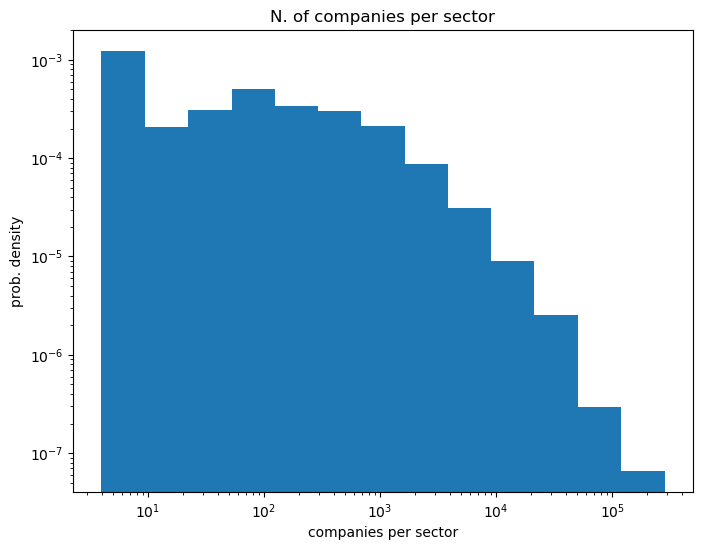

In [3]:
ser_companies_per_sector = pd.Series(df_organizations['sectors'], name = 'sector').explode().dropna().value_counts().sort_index()
n_sectors = ser_companies_per_sector.shape[0]

print(f'N. of specific sectors: {n_sectors}\n')
display(ser_companies_per_sector.sort_values(ascending = False))

n_bins = math.floor(1/2 * pow(ser_companies_per_sector.shape[0], 1/2))
bins = np.logspace(np.log10(ser_companies_per_sector.min()), np.log10(ser_companies_per_sector.max()), n_bins + 1)
bins[0] -= (bins[1] - bins[0]) / 100
bins[-1] += (bins[-1] - bins[-2]) / 100

fig, ax = plt.subplots(figsize = (8, 6))
ax.hist(ser_companies_per_sector, bins = bins, density = True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('companies per sector')
ax.set_ylabel('prob. density')
ax.set_title('N. of companies per sector')
plt.show()

del ser_companies_per_sector

### Settori per compagnia

,founded_on,name,country_code,city,sectors,n_sectors
1299027,2011,Fusion Global Capital,GBR,London,"[Big Data, Business Intelligence, Cloud Comput...",37
1950458,2018,PAZO GROUP,KEN,Nairobi,"[Adventure Travel, Apps, Automotive, B2B, Deli...",29
1423707,2012,The New Music Movement,USA,Harrisburg,"[Asset Management, Business Development, Caree...",27
1187318,2009,VME Advisory,USA,Amherst,"[Angel Investment, Bitcoin, Blockchain, Commer...",26
1952282,2018,Physiola,FRA,Dijon,"[Artificial Intelligence, Automotive, Computer...",26
...,...,...,...,...,...,...
234322,1986,North Coast Roofing Systems,USA,Herndon,[Real Estate],1
1540564,2014,Chesky Partners,USA,Nyack,[Financial Services],1
234325,1986,North Dallas Warehouse Equipment,USA,Dallas,[Warehousing],1
1540542,2014,Chennai SEO Company,IND,Chennai,[SEO],1


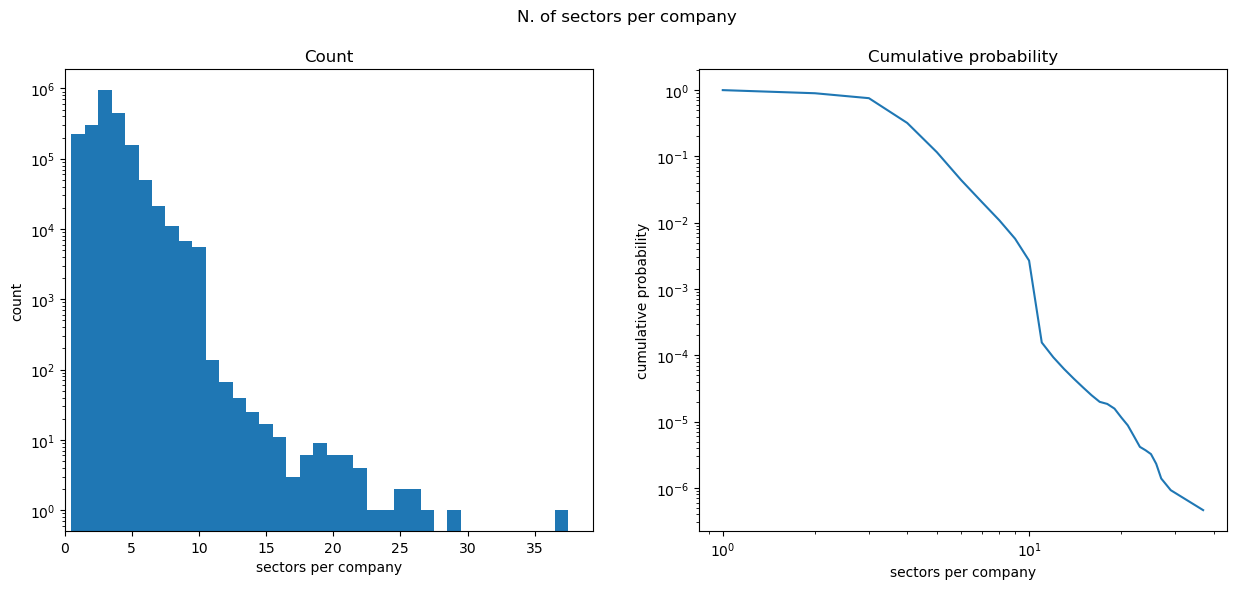

In [4]:
df_stats = df_organizations.assign(n_sectors = df_organizations['sectors'].str.len())
display(df_stats.sort_values('n_sectors', ascending = False))

ser_sectors_per_company = df_stats['n_sectors'].value_counts().sort_index()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.bar(ser_sectors_per_company.index, ser_sectors_per_company.values, width = 1)
ax.set_yscale('log')
ax.set_xlim([0, None])
ax.set_xlabel('sectors per company')
ax.set_ylabel('count')
ax.set_title('Count')

ax = axes[1]
ax.plot(ser_sectors_per_company.iloc[::-1].cumsum().iloc[::-1] / ser_sectors_per_company.sum())
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('sectors per company')
ax.set_ylabel('cumulative probability')
ax.set_title('Cumulative probability')

fig.suptitle('N. of sectors per company')
plt.show()

del df_stats, ser_sectors_per_company

# Evoluzione e rete

In [99]:
# How many years in the past to take data when building network of current year. If 0, only data of current year is used; if None, data of all years is used.
years_past_net_build = 4

In [100]:
%%time
df_evolution, ser_network = compute_evolution(df_organizations, years_past = years_past_net_build)
df_evolution.head()

CPU times: user 16.2 s, sys: 907 ms, total: 17.1 s
Wall time: 17.2 s


,sectors,links
1970,"{'Property Development': 94, 'Property Managem...","{('Property Development', 'Property Management..."
1971,"{'Building Maintenance': 87, 'Construction': 5...","{('Building Maintenance', 'Construction'): 45,..."
1972,"{'Computer': 50, 'Software': 245, 'Tourism': 7...","{('Computer', 'Software'): 23, ('Tourism', 'Tr..."
1973,"{'Accounting': 175, 'Financial Services': 582,...","{('Accounting', 'Financial Services'): 138, ('..."
1974,"{'Farming': 37, 'Landscaping': 50, 'Non Profit...","{('Farming', 'Landscaping'): 2, ('Farming', 'N..."


In [101]:
(
    df_evolution
    .assign(
        n_sectors = df_evolution['sectors'].apply(lambda c: len(c)),
        weight_sectors = df_evolution['sectors'].apply(lambda c: c.total()),
        n_links = df_evolution['links'].apply(lambda c: len(c)),
        weight_links = df_evolution['links'].apply(lambda c: c.total())
    )
    .iloc[-20:]
)

,sectors,links,n_sectors,weight_sectors,n_links,weight_links
2004,"{'Advertising': 3408, 'Information Services': ...","{('Advertising', 'Information Services'): 18, ...",723,160444,28066,210232
2005,"{'Fitness': 427, 'Health Care': 4712, 'E-Comme...","{('Fitness', 'Health Care'): 277, ('E-Commerce...",729,170837,29437,225002
2006,"{'Health Care': 4716, 'Real Estate': 2470, 'E-...","{('E-Commerce', 'Food and Beverage'): 148, ('E...",726,176159,30128,233356
2007,"{'Food and Beverage': 1083, 'Brand Marketing':...","{('Brand Marketing', 'Creative Agency'): 50, (...",725,192019,32677,257919
2008,"{'Developer Tools': 199, 'Real Time': 89, 'Saa...","{('Developer Tools', 'Real Time'): 3, ('Develo...",730,206643,34103,282597
2009,"{'Advertising': 5868, 'Graphic Design': 1377, ...","{('Advertising', 'Graphic Design'): 541, ('Adv...",731,226701,36552,312431
2010,"{'Architecture': 689, 'Interior Design': 535, ...","{('Architecture', 'Interior Design'): 265, ('A...",734,253700,39053,353096
2011,"{'E-Commerce': 6965, 'Fashion': 1595, 'Jewelry...","{('E-Commerce', 'Fashion'): 1015, ('E-Commerce...",734,246793,40044,346969
2012,"{'Marketing': 4291, 'Social Media Marketing': ...","{('Marketing', 'Social Media Marketing'): 190,...",740,277147,42883,393483
2013,"{'Advertising': 6575, 'Email Marketing': 374, ...","{('Advertising', 'Email Marketing'): 180, ('Ad...",735,281193,43948,400438


In [102]:
ser_saturation = pd.Series(index = ser_network.index, dtype = float)
ser_avg_weight = ser_saturation.copy()
ser_max_weight = ser_saturation.copy()
ser_n_nodes = ser_saturation.copy()
ser_n_edges = ser_saturation.copy()
ser_avg_degree_unweighted = ser_saturation.copy()
ser_max_degree_unweighted = ser_saturation.copy()
ser_avg_degree_weighted = ser_saturation.copy()
ser_max_degree_weighted = ser_saturation.copy()

for idx in ser_network.index:
    net = ser_network[idx]
    
    ser_n_nodes[idx] = net.number_of_nodes()
    ser_n_edges[idx] = net.number_of_edges()
    #ser_saturation[idx] = net.number_of_edges() / (net.number_of_nodes() * (net.number_of_nodes() - 1) / 2)
    
    list_weights = list(edge[2] for edge in net.edges(data = 'weight'))
    ser_avg_weight[idx] = sum(list_weights) / len(list_weights)
    ser_max_weight[idx] = max(list_weights)
    
    list_degrees_unweighted = list(d[1] for d in net.degree(weight = None))
    ser_avg_degree_unweighted[idx] = sum(list_degrees_unweighted) / len(list_degrees_unweighted)
    ser_max_degree_unweighted[idx] = max(list_degrees_unweighted)
    
    list_degrees_weighted = list(d[1] for d in net.degree(weight = 'weight'))
    ser_avg_degree_weighted[idx] = sum(list_degrees_weighted) / len(list_degrees_weighted)
    ser_max_degree_weighted[idx] = max(list_degrees_weighted)

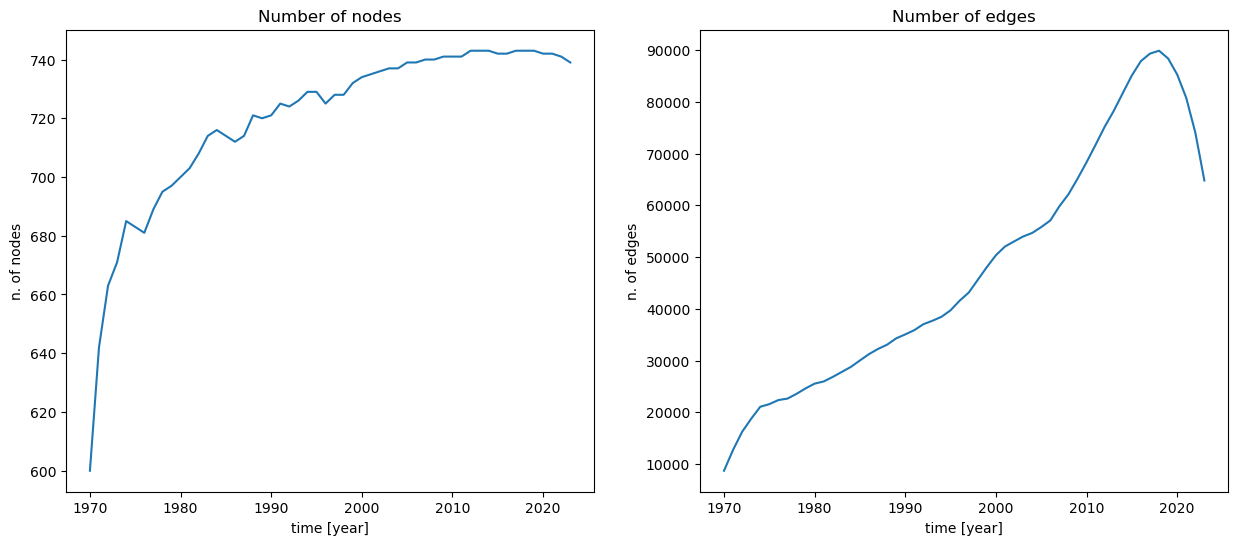

In [103]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.plot(ser_n_nodes)
ax.set_xlabel('time [year]')
ax.set_ylabel('n. of nodes')
ax.set_title('Number of nodes')

ax = axes[1]
ax.plot(ser_n_edges)
ax.set_xlabel('time [year]')
ax.set_ylabel('n. of edges')
ax.set_title('Number of edges')

plt.show()

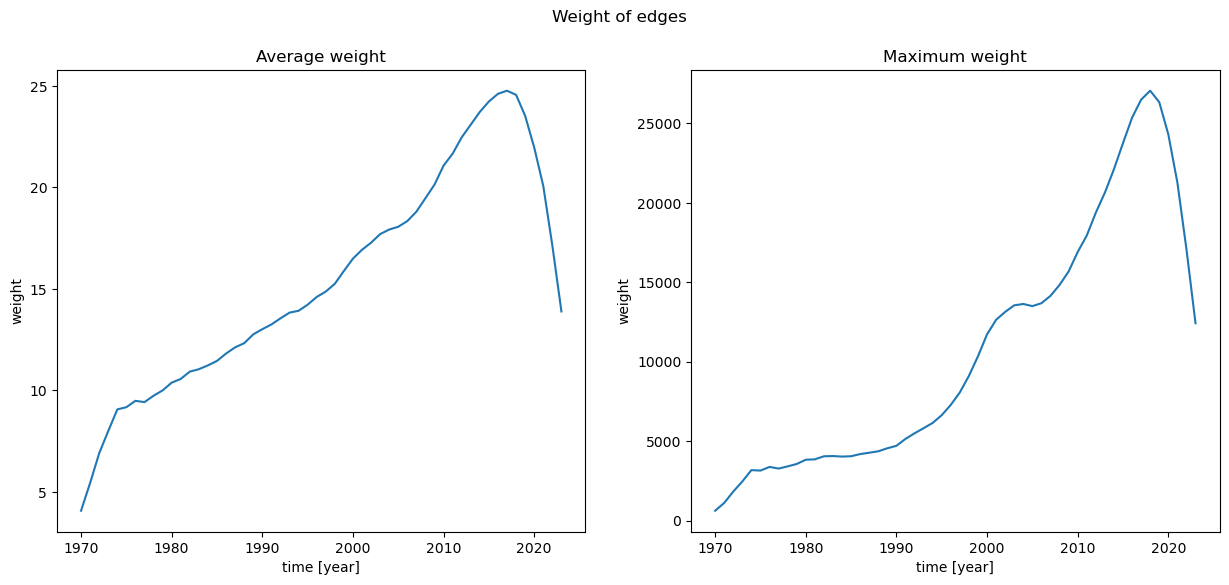

In [104]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.plot(ser_avg_weight)
ax.set_xlabel('time [year]')
ax.set_ylabel('weight')
ax.set_title('Average weight')

ax = axes[1]
ax.plot(ser_max_weight)
ax.set_xlabel('time [year]')
ax.set_ylabel('weight')
ax.set_title('Maximum weight')

fig.suptitle('Weight of edges')
plt.show()

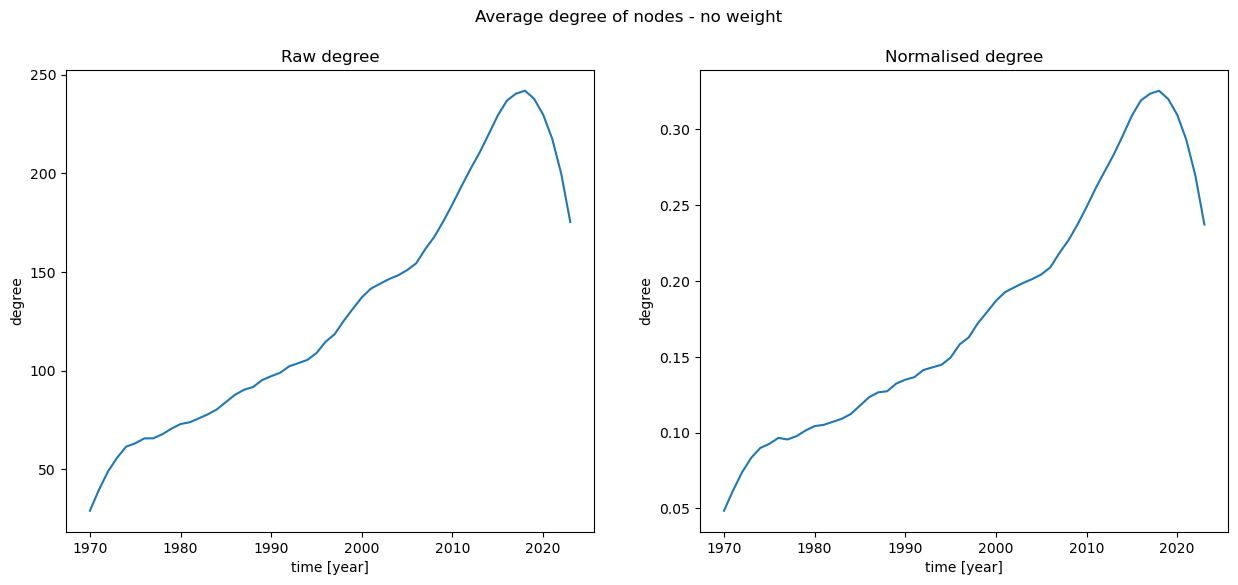

In [105]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.plot(ser_avg_degree_unweighted)
ax.set_xlabel('time [year]')
ax.set_ylabel('degree')
ax.set_title('Raw degree')

ax = axes[1]
ax.plot(ser_avg_degree_unweighted / ser_n_nodes)
ax.set_xlabel('time [year]')
ax.set_ylabel('degree')
ax.set_title('Normalised degree')

fig.suptitle('Average degree of nodes - no weight')
plt.show()

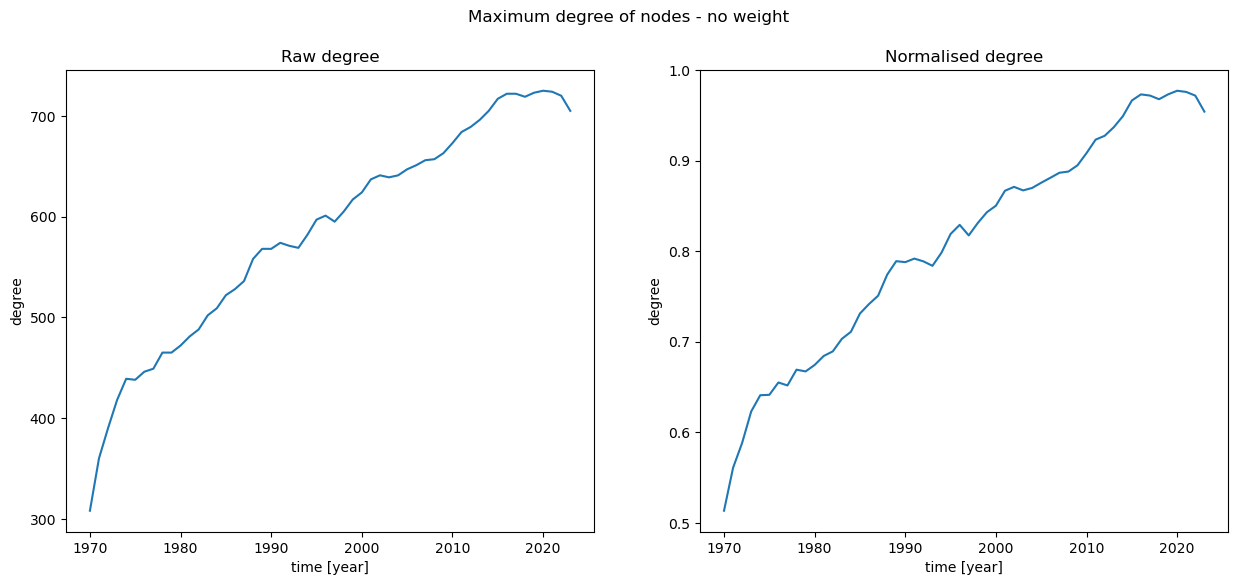

In [106]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.plot(ser_max_degree_unweighted)
ax.set_xlabel('time [year]')
ax.set_ylabel('degree')
ax.set_title('Raw degree')

ax = axes[1]
ax.plot(ser_max_degree_unweighted / ser_n_nodes)
ax.set_xlabel('time [year]')
ax.set_ylabel('degree')
ax.set_title('Normalised degree')

fig.suptitle('Maximum degree of nodes - no weight')
plt.show()

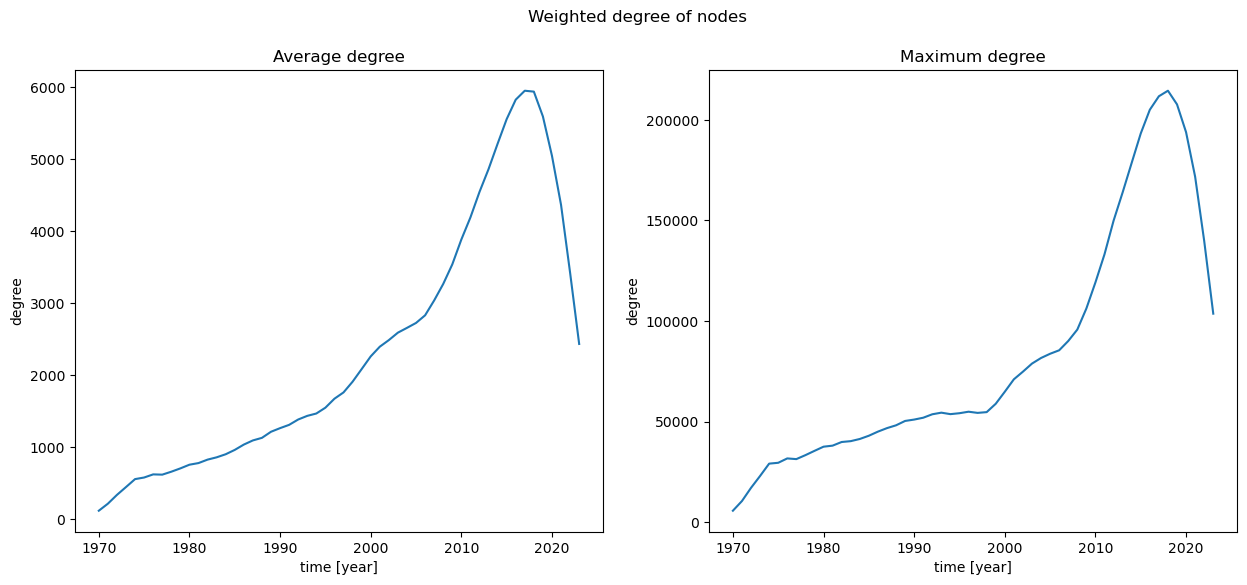

In [107]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.plot(ser_avg_degree_weighted)
ax.set_xlabel('time [year]')
ax.set_ylabel('degree')
ax.set_title('Average degree')

ax = axes[1]
ax.plot(ser_max_degree_weighted)
ax.set_xlabel('time [year]')
ax.set_ylabel('degree')
ax.set_title('Maximum degree')

fig.suptitle('Weighted degree of nodes')
plt.show()

# Rete al tempo finale

In [108]:
net = ser_network.iloc[-1]
names, weights = zip(*list(net.nodes(data = 'weight')))
names, degrees_weighted = zip(*list(net.degree(weight = 'weight')))
names, degrees_unweighted = zip(*list(net.degree(weight = None)))

pd.DataFrame(
    {'n_companies': weights, 'degree_unweighted': degrees_unweighted, 'degree_weighted': degrees_weighted},
    index = names
).sort_values('degree_weighted', ascending = False)

,n_companies,degree_unweighted,degree_weighted
Software,36048,705,103676
Information Technology,27150,690,79693
Consulting,14892,618,41551
E-Commerce,15475,620,39789
Financial Services,15608,488,38134
...,...,...,...
Google Glass,4,11,11
Ferry Service,3,8,9
Flash Storage,2,8,8
Nintendo,2,5,8


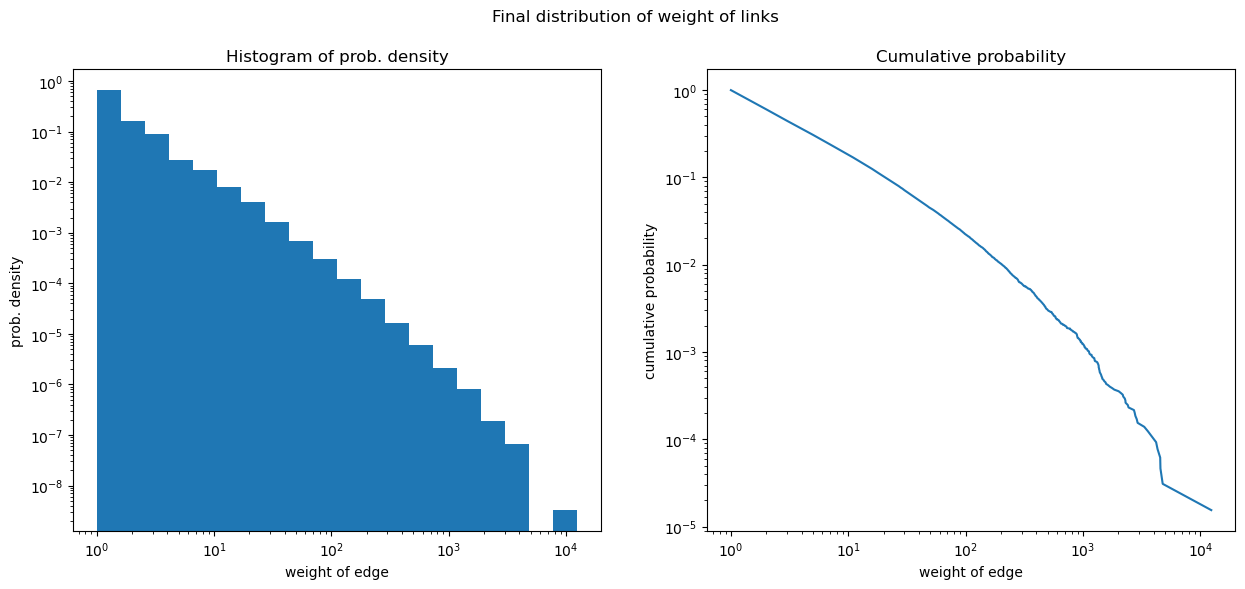

In [109]:
arr_edges_weight = np.array(list(edge[2] for edge in list(ser_network.iloc[-1].edges.data('weight'))))
n_bins = 5 * math.floor(np.log10(arr_edges_weight.max()))
bins = np.logspace(0, np.log10(arr_edges_weight.max()), n_bins + 1)
bins[-1] += (bins[-1] - bins[-2]) / 100

df_stats = pd.DataFrame(clc.Counter(arr_edges_weight).items(), columns = ['weight', 'population']).sort_values('weight')
df_stats['cumul_population'] = df_stats.loc[::-1, 'population'].cumsum()[::-1]
df_stats['cumul_probability'] = df_stats['cumul_population'] / df_stats['population'].sum()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.hist(arr_edges_weight, bins = bins, density = True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('weight of edge')
ax.set_ylabel('prob. density')
ax.set_title('Histogram of prob. density')

ax = axes[1]
ax.plot(df_stats['weight'], df_stats['cumul_probability'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('weight of edge')
ax.set_ylabel('cumulative probability')
ax.set_title('Cumulative probability')

fig.suptitle('Final distribution of weight of links')
plt.show()

#display(df_stats)

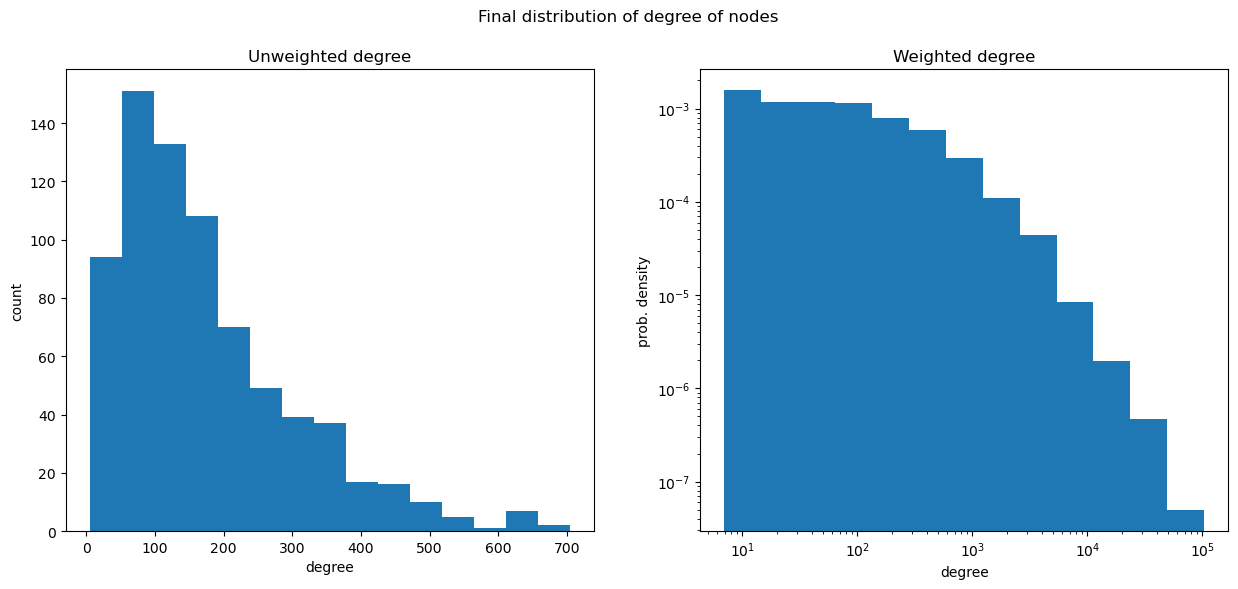

In [110]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

arr_nodes_degree_unweighted = np.array(list(node[1] for node in list(ser_network.iloc[-1].degree(weight = None))))

ax = axes[0]
ax.hist(arr_nodes_degree_unweighted, bins = 'doane')
ax.set_xlabel('degree')
ax.set_ylabel('count')
ax.set_title('Unweighted degree')

arr_nodes_degree_weighted = np.array(list(node[1] for node in list(ser_network.iloc[-1].degree(weight = 'weight'))))
n_bins = math.floor(1/2 * pow(arr_nodes_degree_weighted.shape[0], 1/2))
bins = np.logspace(np.log10(arr_nodes_degree_weighted.min()), np.log10(arr_nodes_degree_weighted.max()), n_bins + 1)
bins[0] -= (bins[1] - bins[0]) / 100
bins[-1] += (bins[-1] - bins[-2]) / 100

ax = axes[1]
ax.hist(arr_nodes_degree_weighted, bins = bins, density = True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('degree')
ax.set_ylabel('prob. density')
ax.set_title('Weighted degree')

fig.suptitle('Final distribution of degree of nodes')
plt.show()

# Innovazione

In [111]:
df_time_start = (
    df_evolution.reset_index()[['index', 'links']].explode('links')
    .rename(columns = {'index': 'time_link'})
    .groupby('links').first().reset_index()
)
df_time_start[['sector_1','sector_2']] = pd.DataFrame(df_time_start['links'].tolist(), index = df_time_start.index)
df_time_start = df_time_start[['sector_1', 'sector_2', 'time_link']]

ser_sector_start = (
    df_evolution.reset_index()[['index', 'sectors']].explode('sectors')
    .rename(columns = {'sectors': 'sector'})
    .groupby('sector')['index'].first()
)
df_time_start['time_sector_1'] = ser_sector_start[df_time_start['sector_1']].values
df_time_start['time_sector_2'] = ser_sector_start[df_time_start['sector_2']].values
df_time_start['time_sector_max'] = df_time_start[['time_sector_1', 'time_sector_2']].max(axis = 1)
df_time_start['time_diff'] = df_time_start['time_link'] - df_time_start['time_sector_max']

df_time_start

,sector_1,sector_2,time_link,time_sector_1,time_sector_2,time_sector_max,time_diff
0,3D Printing,3D Technology,1970,1970,1970,1970,0
1,3D Printing,Ad Network,2011,1970,1974,1974,37
2,3D Printing,Adult,2017,1970,1970,1970,47
3,3D Printing,Advanced Materials,1983,1970,1970,1970,13
4,3D Printing,Advertising,1971,1970,1970,1970,1
...,...,...,...,...,...,...,...
131307,macOS,Web Hosting,1998,1982,1970,1982,16
131308,macOS,WebOS,1998,1982,1975,1982,16
131309,macOS,Windows,1984,1982,1970,1982,2
131310,macOS,Windows Phone,2015,1982,1977,1982,33


PROBLEMA

In [112]:
ser_sector_start

sector
3D Printing      1970
3D Technology    1970
A/B Testing      1976
Accounting       1970
Ad Exchange      1988
                 ... 
Young Adults     1970
eSports          1970
iOS              1970
mHealth          1970
macOS            1982
Name: index, Length: 743, dtype: int32

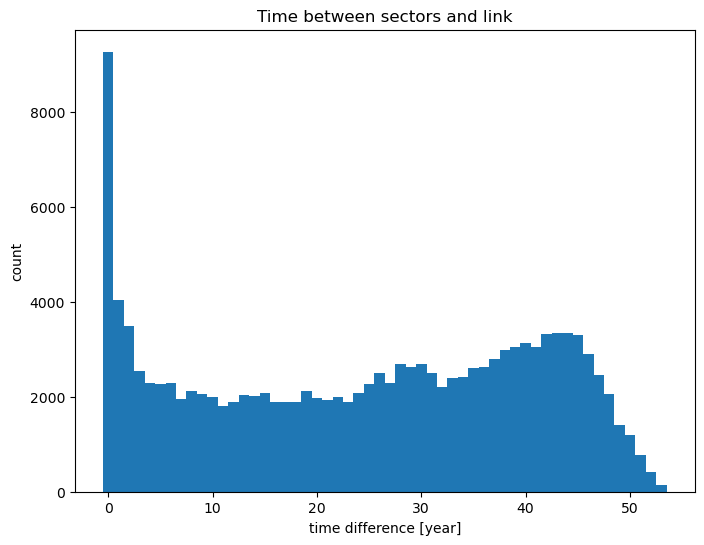

In [113]:
data = df_time_start['time_diff'].value_counts(sort = False).sort_index()

fig, ax = plt.subplots(figsize = (8, 6))
ax.bar(data.index, data.values, width = 1)
ax.set_ylim([0, None])
ax.set_xlabel('time difference [year]')
ax.set_ylabel('count')
ax.set_title('Time between sectors and link')
plt.show()

# Ecosistema

In [114]:
%%time

country = 'ITA'
city = 'Milan'

df_evolution_sub, ser_network_sub = compute_evolution(
    df_organizations,
    sel_subnet = (df_organizations['country_code'] == country) & (df_organizations['city'] == city),
    years_past = years_past_net_build
)

CPU times: user 1.03 s, sys: 31.5 ms, total: 1.06 s
Wall time: 1.07 s


### Confronto al tempo finale

In [115]:
arr_sectors_sel = df_organizations.loc[
    (df_organizations['country_code'] == country) & (df_organizations['city'] == city), 'sectors'
].explode().unique()

for text, net, selection in [
    ['GLOBAL NETWORK', ser_network.iloc[-1], pd.Series(index = df_organizations.index, data = True)],
    #['\nECOSYSTEM', ser_network.iloc[-1].subgraph(arr_sectors_sel)]
    ['\nECOSYSTEM', ser_network_sub.iloc[-1], (df_organizations['country_code'] == country) & (df_organizations['city'] == city)]
]:
    arr_degrees_unweighted = np.array(list(degree for node, degree in net.degree(weight = None)))
    arr_degrees_weighted = np.array(list(degree for node, degree in net.degree(weight = 'weight')))
    print(text)
    print(f'N. of sectors: {net.number_of_nodes()}')
    print(f'N. of edges: {net.number_of_edges()}')
    print(f'N. of companies: {df_organizations.loc[selection].shape[0]}')
    print(f'Average degree (unweighted): {arr_degrees_unweighted.mean() : .2f}')
    print(f'Max degree (unweighted): {arr_degrees_unweighted.max()}')
    print(f'Average degree (weighted): {arr_degrees_weighted.mean() : .2f}')
    print(f'Max degree (weighted): {arr_degrees_weighted.max()}')

GLOBAL NETWORK
N. of sectors: 739
N. of edges: 64786
N. of companies: 2168548
Average degree (unweighted):  175.33
Max degree (unweighted): 705
Average degree (weighted):  2434.62
Max degree (weighted): 103676

ECOSYSTEM
N. of sectors: 384
N. of edges: 2059
N. of companies: 4260
Average degree (unweighted):  10.72
Max degree (unweighted): 143
Average degree (weighted):  16.25
Max degree (weighted): 317


In [116]:
net = ser_network.iloc[-1].subgraph(arr_sectors_sel)
names, weights = zip(*list(net.nodes(data = 'weight')))
names, degrees_weighted = zip(*list(net.degree(weight = 'weight')))
names, degrees_unweighted = zip(*list(net.degree(weight = None)))

pd.DataFrame(
    {'n_companies': weights, 'degree_unweighted': degrees_unweighted, 'degree_weighted': degrees_weighted},
    index = names
).sort_values('n_companies', ascending = False)

,n_companies,degree_unweighted,degree_weighted
Software,36048,593,102149
Information Technology,27150,585,78854
Health Care,16102,482,36555
Financial Services,15608,441,37769
E-Commerce,15475,547,39347
...,...,...,...
Gift Exchange,9,12,26
Cause Marketing,8,24,37
Ediscovery,8,20,28
In-Flight Entertainment,5,14,17


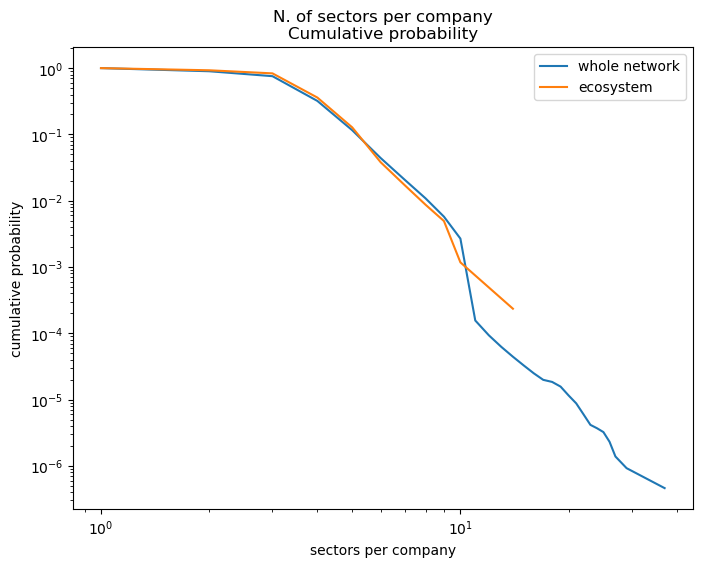

In [117]:
fig, ax = plt.subplots(figsize = (8, 6))

for text, selection in [
    ['whole network', pd.Series(index = df_organizations.index, data = True)],
    ['ecosystem', (df_organizations['country_code'] == country) & (df_organizations['city'] == city)]
]:
    ser_sectors_per_company = df_organizations.loc[selection, 'sectors'].str.len().value_counts().sort_index()
    ax.plot(ser_sectors_per_company.iloc[::-1].cumsum().iloc[::-1] / ser_sectors_per_company.sum(), label = text)

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('sectors per company')
ax.set_ylabel('cumulative probability')
ax.set_title('N. of sectors per company\nCumulative probability')

plt.show()

#### Distribuzione dei pesi dei nodi e dei collegamenti <br/> Confronto tra ecosistema e rete totale

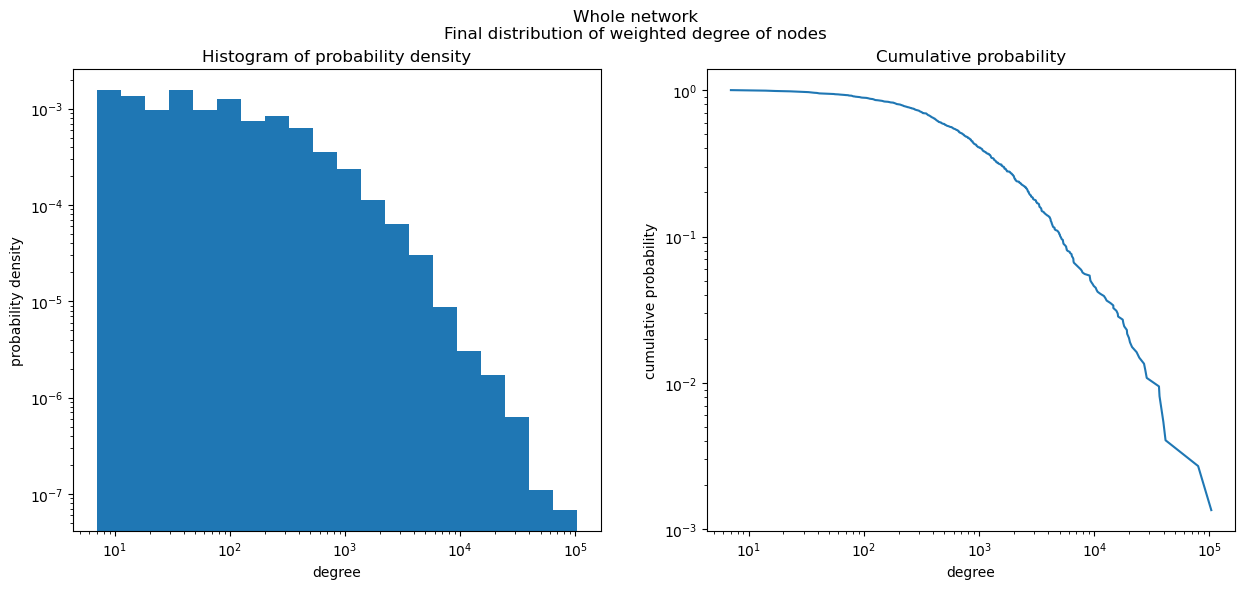

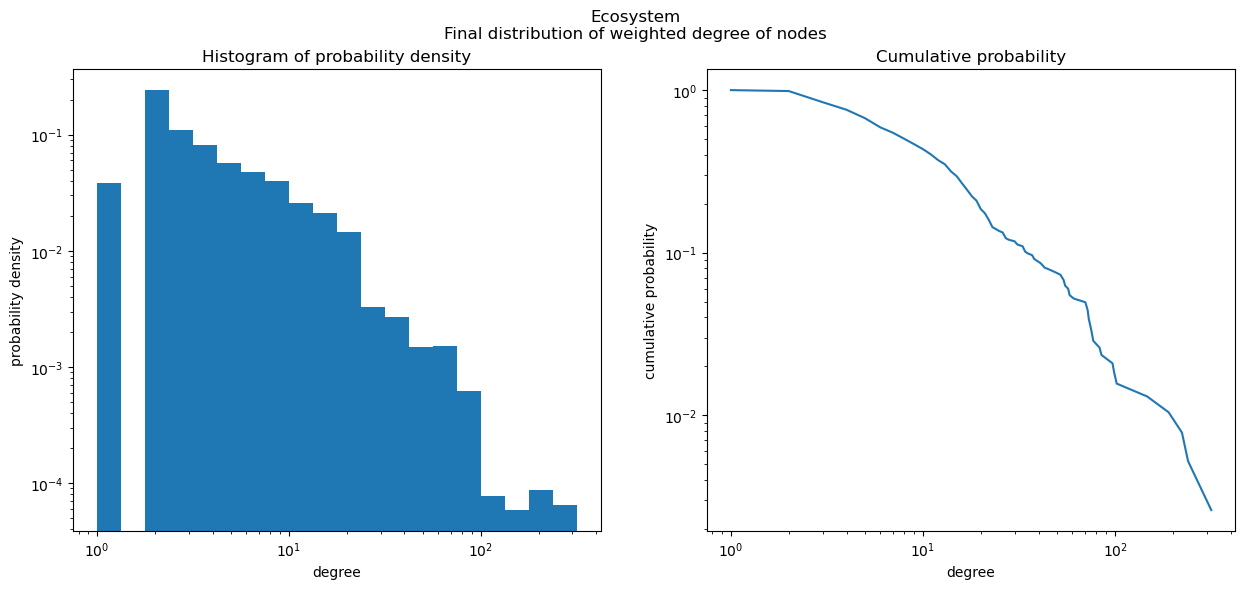

In [118]:
for s, text in [(ser_network, 'Whole network'), (ser_network_sub, 'Ecosystem')]:
    list_degrees_weighted = list(d[1] for d in s.iloc[-1].degree(weight = 'weight') if d[1] > 0)
    ser_degrees_weighted = pd.Series(list_degrees_weighted).value_counts().sort_index()
    
    #n_bins = math.floor(1 * pow(len(list_degrees_weighted), 1/2))
    n_bins = 20
    bins = np.logspace(np.log10(min(list_degrees_weighted)), np.log10(max(list_degrees_weighted)), n_bins + 1)
    bins[0] -= (bins[1] - bins[0]) / 100
    bins[-1] += (bins[-1] - bins[-2]) / 100
    
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))
    
    ax = axes[0]
    ax.hist(list_degrees_weighted, bins = bins, density = True)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('degree')
    ax.set_ylabel('probability density')
    ax.set_title('Histogram of probability density')
    
    ax = axes[1]
    ax.plot(ser_degrees_weighted.iloc[::-1].cumsum().iloc[::-1] / ser_degrees_weighted.sum())
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('degree')
    ax.set_ylabel('cumulative probability')
    ax.set_title('Cumulative probability')
    
    fig.suptitle(f'{text}\nFinal distribution of weighted degree of nodes')
    plt.show()

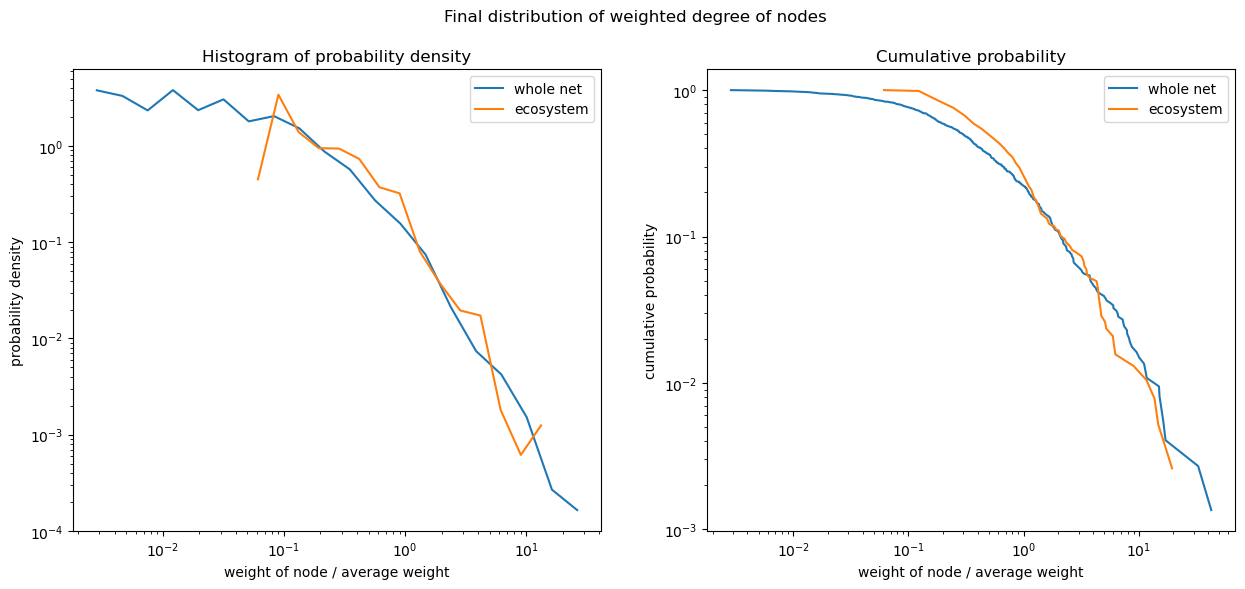

In [119]:
iter_parameters = [(ser_network.iloc[-1], 20), (ser_network_sub.iloc[-1], 15)]
#iter_parameters = [(ser_network.iloc[-1], 15), (ser_network_sub.iloc[-1], 10)]

labels = ['whole net', 'ecosystem']
weights_nodes = [None, None]
weights_nodes_renorm = [None, None]
weights_nodes_cumul = [None, None]
bins = [None, None]
hist_values = [None, None]

for i in range(len(iter_parameters)):
    net, n_bins = iter_parameters[i]
    weights_nodes[i] = np.array(list(d[1] for d in net.degree(weight = 'weight') if d[1] > 0))
    weights_nodes_renorm[i] = weights_nodes[i] / weights_nodes[i].mean()
    weights_nodes_cumul[i] = pd.Series(weights_nodes_renorm[i]).value_counts().sort_index()
    weights_nodes_cumul[i] = weights_nodes_cumul[i][::-1].cumsum()[::-1] / weights_nodes_cumul[i].sum()
    
    bins[i] = np.logspace(np.log10(min(weights_nodes_renorm[i])), np.log10(max(weights_nodes_renorm[i])), n_bins + 1)
    bins[i][0] -= (bins[i][1] - bins[i][0]) / 100
    bins[i][-1] += (bins[i][-1] - bins[i][-2]) / 100
    hist_values[i], bins[i] = np.histogram(weights_nodes_renorm[i], bins = bins[i], density = True)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
for i in range(len(iter_parameters)):
    ax.plot(bins[i][:-1], hist_values[i], label = labels[i])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('weight of node / average weight')
ax.set_ylabel('probability density')
ax.set_title('Histogram of probability density')

ax = axes[1]
for i in range(len(iter_parameters)):
    ax.plot(weights_nodes_cumul[i], label = labels[i])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('weight of node / average weight')
ax.set_ylabel('cumulative probability')
ax.set_title('Cumulative probability')

fig.suptitle('Final distribution of weighted degree of nodes')
plt.show()
del labels, weights_nodes, weights_nodes_renorm, weights_nodes_cumul, bins, hist_values

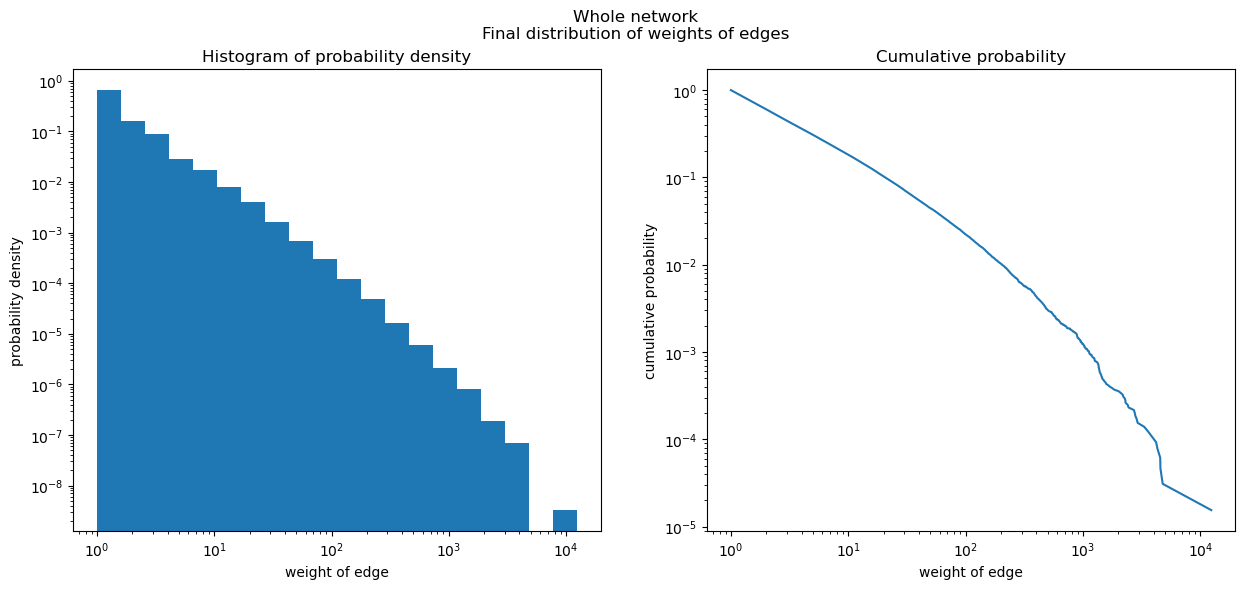

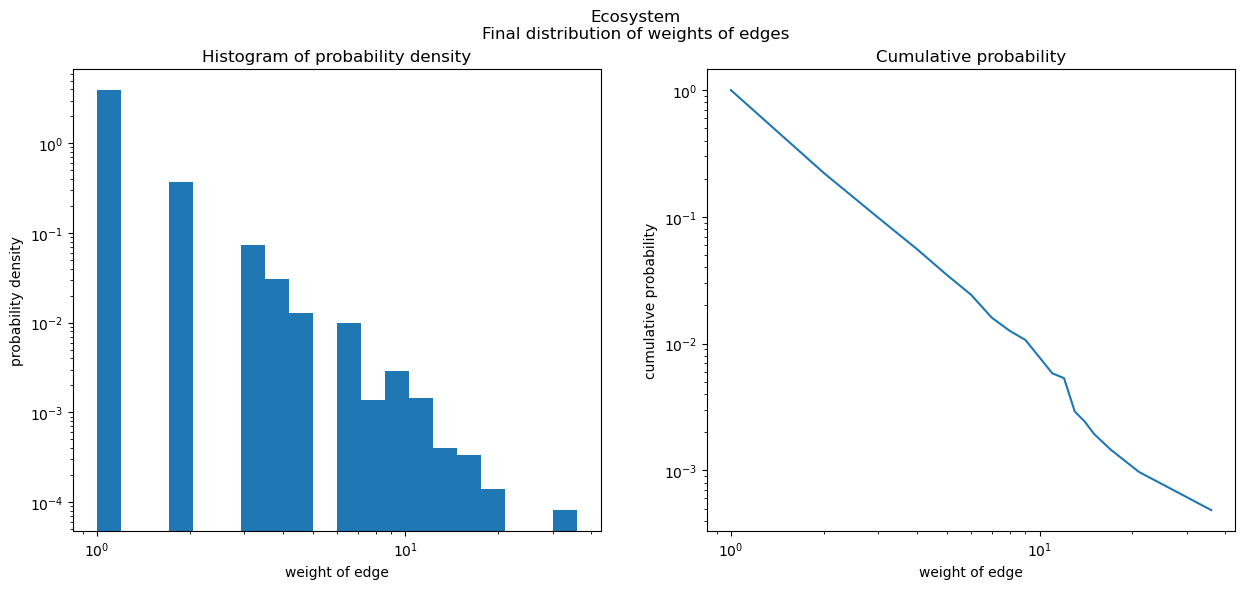

In [120]:
for s, text in [(ser_network, 'Whole network'), (ser_network_sub, 'Ecosystem')]:
    list_edges_weighted = list(edge[2] for edge in s.iloc[-1].edges(data = 'weight'))
    ser_edges_weighted = pd.Series(list_edges_weighted).value_counts().sort_index()
    
    #n_bins = math.floor(1/10 * pow(len(list_edges_weighted), 1/2))
    n_bins = 20
    bins = np.logspace(np.log10(min(list_edges_weighted)), np.log10(max(list_edges_weighted)), n_bins + 1)
    bins[0] -= (bins[1] - bins[0]) / 100
    bins[-1] += (bins[-1] - bins[-2]) / 100
    
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))
    
    ax = axes[0]
    ax.hist(list_edges_weighted, bins = bins, density = True)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('weight of edge')
    ax.set_ylabel('probability density')
    ax.set_title('Histogram of probability density')
    
    ax = axes[1]
    ax.plot(ser_edges_weighted.iloc[::-1].cumsum().iloc[::-1] / ser_edges_weighted.sum())
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('weight of edge')
    ax.set_ylabel('cumulative probability')
    ax.set_title('Cumulative probability')
    
    fig.suptitle(f'{text}\nFinal distribution of weights of edges')
    plt.show()

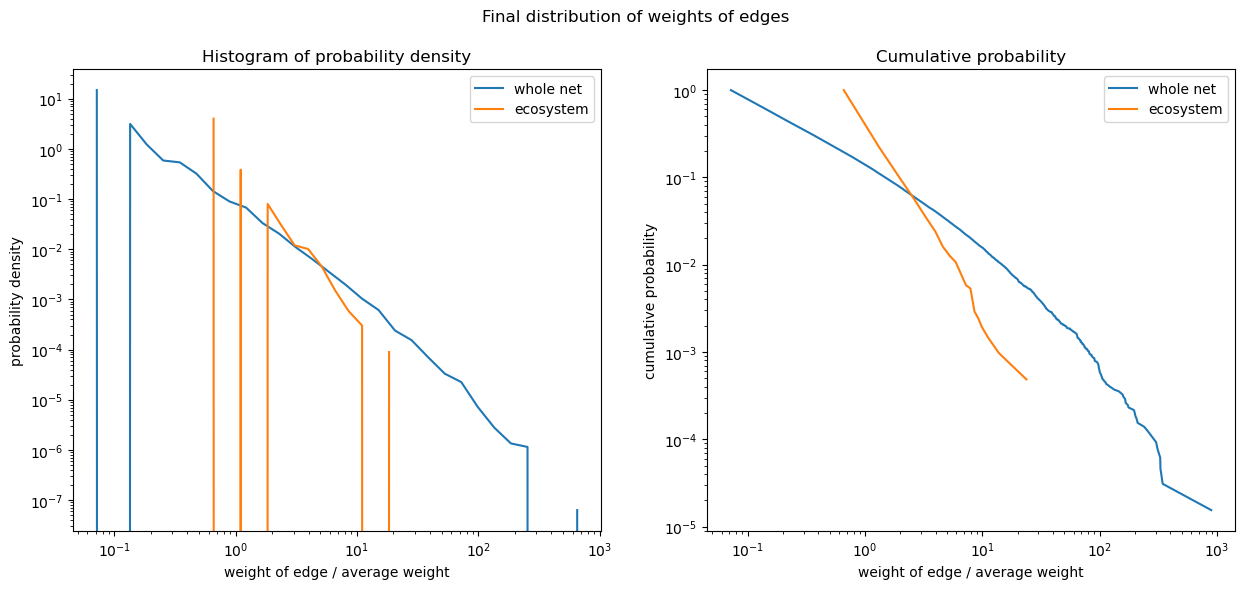

In [121]:
iter_parameters = [(ser_network.iloc[-1], 30), (ser_network_sub.iloc[-1], 14)]
#iter_parameters = [(ser_network.iloc[-1], 15), (ser_network_sub.iloc[-1], 6)]

labels = ['whole net', 'ecosystem']
weights_edges = [None, None]
weights_edges_renorm = [None, None]
weights_edges_cumul = [None, None]
bins = [None, None]
hist_values = [None, None]

for i in range(len(iter_parameters)):
    net, n_bins = iter_parameters[i]
    weights_edges[i] = np.array(list(edge[2] for edge in net.edges(data = 'weight')))
    weights_edges_renorm[i] = weights_edges[i] / weights_edges[i].mean()
    weights_edges_cumul[i] = pd.Series(weights_edges_renorm[i]).value_counts().sort_index()
    weights_edges_cumul[i] = weights_edges_cumul[i][::-1].cumsum()[::-1] / weights_edges_cumul[i].sum()
    
    bins[i] = np.logspace(np.log10(min(weights_edges_renorm[i])), np.log10(max(weights_edges_renorm[i])), n_bins + 1)
    bins[i][0] -= (bins[i][1] - bins[i][0]) / 100
    bins[i][-1] += (bins[i][-1] - bins[i][-2]) / 100
    hist_values[i], bins[i] = np.histogram(weights_edges_renorm[i], bins = bins[i], density = True)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
for i in range(len(iter_parameters)):
    ax.plot(bins[i][:-1], hist_values[i], label = labels[i])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('weight of edge / average weight')
ax.set_ylabel('probability density')
ax.set_title('Histogram of probability density')

ax = axes[1]
for i in range(len(iter_parameters)):
    ax.plot(weights_edges_cumul[i], label = labels[i])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('weight of edge / average weight')
ax.set_ylabel('cumulative probability')
ax.set_title('Cumulative probability')

fig.suptitle('Final distribution of weights of edges')
plt.show()
del labels, weights_edges, weights_edges_renorm, weights_edges_cumul, bins, hist_values

### Evoluzione 

In [122]:
ser_saturation_sub = pd.Series(index = ser_network_sub.index, dtype = float)
ser_n_nodes_sub = ser_saturation_sub.copy()
ser_n_edges_sub = ser_saturation_sub.copy()
ser_avg_degree_unweighted_sub = ser_saturation_sub.copy()
ser_max_degree_unweighted_sub = ser_saturation_sub.copy()

for idx in ser_network.index:
    net = ser_network_sub[idx]
    if (net):
        ser_n_nodes_sub[idx] = net.number_of_nodes()
        ser_n_edges_sub[idx] = net.number_of_edges()
        #ser_saturation_sub[idx] = net.number_of_edges() / (net.number_of_nodes() * (net.number_of_nodes() - 1) / 2)

        list_degrees_unweighted = list(d[1] for d in net.degree(weight = None))
        ser_avg_degree_unweighted_sub[idx] = sum(list_degrees_unweighted) / len(list_degrees_unweighted)
        ser_max_degree_unweighted_sub[idx] = max(list_degrees_unweighted)

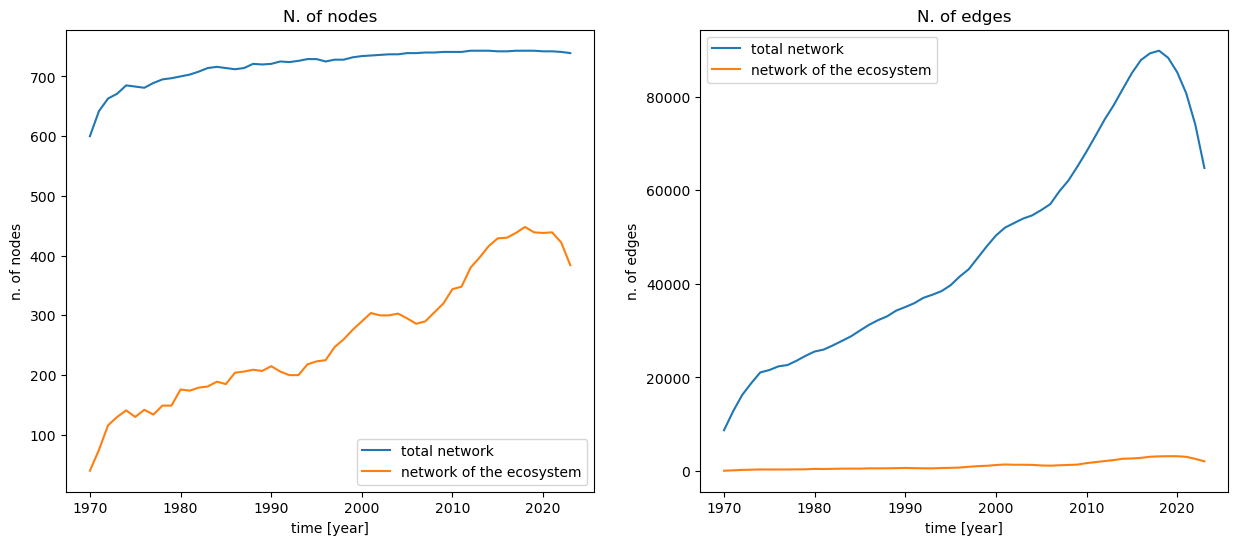

In [123]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.plot(ser_n_nodes, label = 'total network')
ax.plot(ser_n_nodes_sub, label = 'network of the ecosystem')
ax.legend()
ax.set_xlabel('time [year]')
ax.set_ylabel('n. of nodes')
ax.set_title('N. of nodes')

ax = axes[1]
ax.plot(ser_n_edges, label = 'total network')
ax.plot(ser_n_edges_sub, label = 'network of the ecosystem')
ax.legend()
ax.set_xlabel('time [year]')
ax.set_ylabel('n. of edges')
ax.set_title('N. of edges')

plt.show()

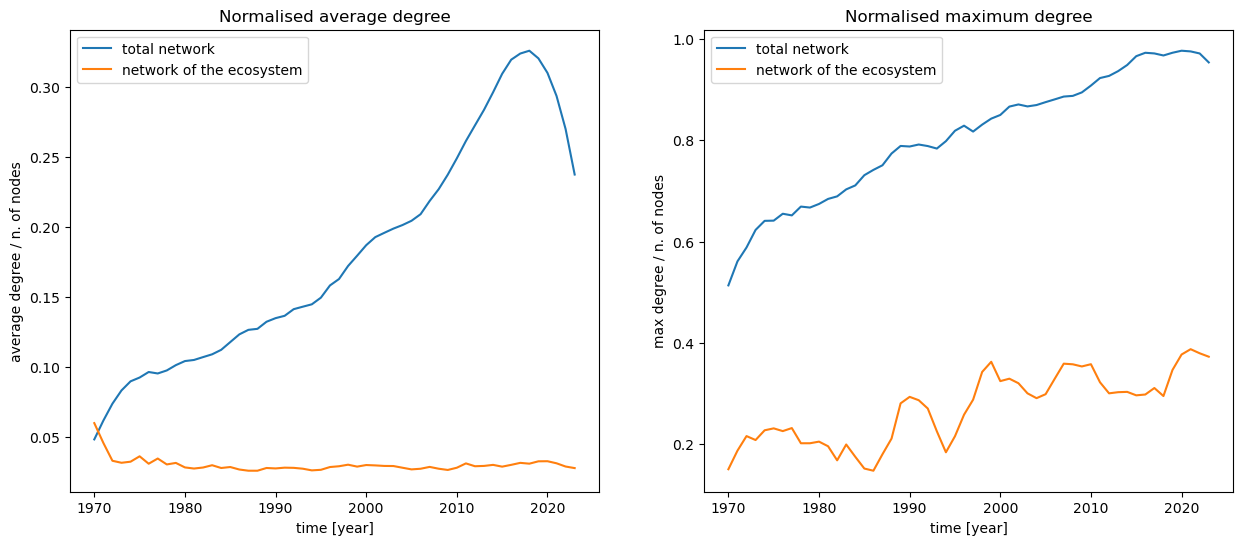

In [124]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.plot(ser_avg_degree_unweighted / ser_n_nodes, label = 'total network')
ax.plot(ser_avg_degree_unweighted_sub / ser_n_nodes_sub, label = 'network of the ecosystem')
ax.legend()
ax.set_xlabel('time [year]')
ax.set_ylabel('average degree / n. of nodes')
ax.set_title('Normalised average degree')

ax = axes[1]
ax.plot(ser_max_degree_unweighted / ser_n_nodes, label = 'total network')
ax.plot(ser_max_degree_unweighted_sub / ser_n_nodes_sub, label = 'network of the ecosystem')
ax.legend()
ax.set_xlabel('time [year]')
ax.set_ylabel('max degree / n. of nodes')
ax.set_title('Normalised maximum degree')

plt.show()

In [125]:
%%time

approximation = True

def calc_both_diameters(time, approximate = False):
    print(f'\r{time}', end = '', flush = True)
    return(
        calc_diameter(ser_network[time], approximate = approximate),
        calc_diameter(ser_network_sub[time], approximate = approximate)
    )

def calc_diameter(net, approximate = False):
    if (not net):
        return None
    nodes_max_component = sorted(nx.connected_components(net), key = len, reverse = True)[0]
    net_max_component = net.subgraph(nodes_max_component)
    if approximate:
        return nx.approximation.diameter(net_max_component)
    else:
        return nx.diameter(net_max_component)

print(f'Computing evolution of diameter between {ser_network.index[0]} and {ser_network.index[-1]}...')
if approximation:
    list_diameter = list(calc_both_diameters(time, approximate = True) for time in ser_network.index)
else:
    list_diameter = jbl.Parallel(n_jobs = -1)(jbl.delayed(calc_both_diameters)(time) for time in ser_network.index)
ser_diameter = pd.Series(index = ser_network.index, data = list(x[0] for x in list_diameter))
ser_diameter_sub = pd.Series(index = ser_network.index, data = list(x[1] for x in list_diameter))
print('\nDone.')

Computing evolution of diameter between 1970 and 2023...
2023
Done.
CPU times: user 2.35 s, sys: 19.6 ms, total: 2.37 s
Wall time: 2.38 s


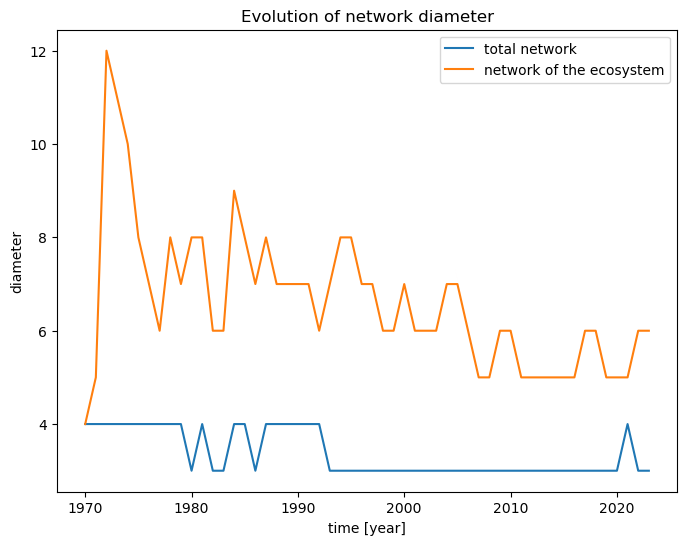

In [126]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(ser_diameter, label = 'total network')
ax.plot(ser_diameter_sub, label = 'network of the ecosystem')
#ax.set_ylim(0, None)
ax.legend()
ax.set_xlabel('time [year]')
ax.set_ylabel('diameter')
ax.set_title('Evolution of network diameter')
plt.show()

In [127]:
%%time

def compute_bridged_distances(df_evolution, ser_network, verbose = False):
    df_new_edges = pd.DataFrame(index = df_evolution.index[1:])
    df_new_edges['to_new_node'] = 0
    df_new_edges['to_disconn_component'] = 0
    df_new_edges['bridged_distances'] = [clc.Counter()] * df_new_edges.shape[0]

    if verbose:
        print(f'Computing bridged distances between {df_new_edges.index[0]} and {df_new_edges.index[-1]}...')
    for t in range(df_new_edges.shape[0]):
        idx = df_new_edges.index[t]
        if verbose:
            print(f'\r{idx}', end = '', flush = True)
        net = ser_network.iloc[t]
        list_distances = list()
        counter_links = df_evolution.iloc[t + 1]['links']
        for link, value in counter_links.items():
            try:
                d = nx.shortest_path_length(net, *link, weight = None)
                list_distances.append(d)
            except nx.NodeNotFound:
                df_new_edges.loc[idx, 'to_new_node'] += 1
            except nx.NetworkXNoPath:
                df_new_edges.loc[idx, 'to_disconn_component'] += 1
        df_new_edges.at[idx, 'bridged_distances'] = clc.Counter(list_distances)

    df_new_edges['avg_bridged_dist'] = df_new_edges['bridged_distances'].apply(lambda c: sum(key * count for key, count in c.items()) / c.total())
    df_new_edges['max_bridged_dist'] = df_new_edges['bridged_distances'].apply(lambda c: max(c.keys()))
    if verbose:
        print('\nDone.')
    return df_new_edges

df_new_edges = compute_bridged_distances(df_evolution, ser_network, verbose = True)
df_new_edges_sub = compute_bridged_distances(df_evolution_sub, ser_network_sub, verbose = False)

Computing bridged distances between 1971 and 2023...
2023
Done.
CPU times: user 19.3 s, sys: 30.3 ms, total: 19.3 s
Wall time: 19.4 s


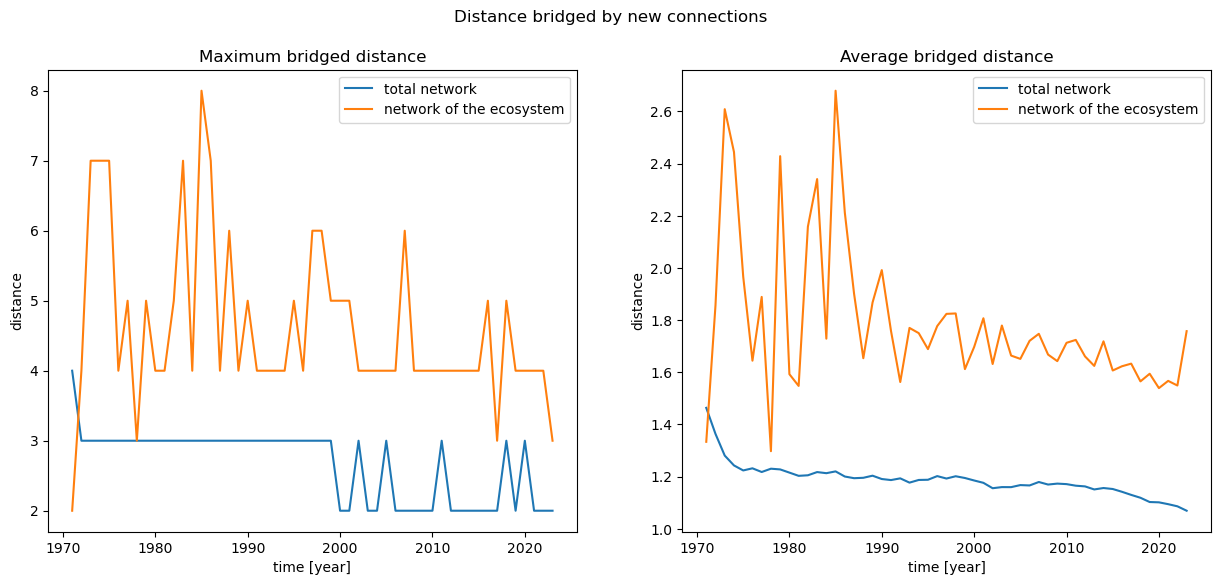

In [128]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.plot(df_new_edges['max_bridged_dist'], label = 'total network')
ax.plot(df_new_edges_sub['max_bridged_dist'], label = 'network of the ecosystem')
ax.legend()
ax.set_xlabel('time [year]')
ax.set_ylabel('distance')
ax.set_title('Maximum bridged distance')

ax = axes[1]
ax.plot(df_new_edges['avg_bridged_dist'], label = 'total network')
ax.plot(df_new_edges_sub['avg_bridged_dist'], label = 'network of the ecosystem')
ax.legend()
ax.set_xlabel('time [year]')
ax.set_ylabel('distance')
ax.set_title('Average bridged distance')

fig.suptitle('Distance bridged by new connections')
plt.show()

In [129]:
ser_centrality = pd.Series(
    index = ser_network.index,
    data = list(nx.group_closeness_centrality(ser_network[idx], ser_network_sub[idx].nodes(), weight = None) for idx in ser_network.index)
)

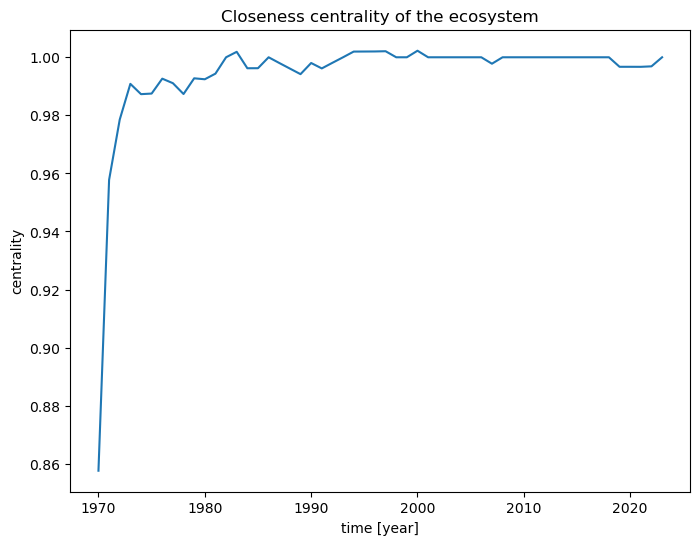

In [130]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(ser_centrality)
ax.set_xlabel('time [year]')
ax.set_ylabel('centrality')
ax.set_title('Closeness centrality of the ecosystem')
plt.show()

In [131]:
%%time

ser_eigen_norm_sub_unweighted = pd.Series(index = ser_network.index)
ser_eigen_norm_sub_weighted = pd.Series(index = ser_network.index)

print(f'Computing eigenvector centrality between {ser_network.index[0]} and {ser_network.index[-1]}...')
for t in range(ser_network.shape[0]):
    idx = ser_network.index[t]
    print(f'\r{idx}', end = '', flush = True)
    
    dict_centrality_unweighted = nx.eigenvector_centrality(ser_network[idx], weight = None)
    ser_eigen_norm_sub_unweighted[idx] = np.linalg.norm(np.array(
        list(dict_centrality_unweighted[key] for key in ser_network_sub[idx].nodes())
    ))
    
    dict_centrality_weighted = nx.eigenvector_centrality(ser_network[idx], weight = 'weight')
    ser_eigen_norm_sub_weighted[idx] = np.linalg.norm(np.array(
        list(dict_centrality_weighted[key] for key in ser_network_sub[idx].nodes())
    ))
    
print('\nDone.')

Computing eigenvector centrality between 1970 and 2023...
2023
Done.
CPU times: user 46.4 s, sys: 47.1 ms, total: 46.5 s
Wall time: 46.7 s


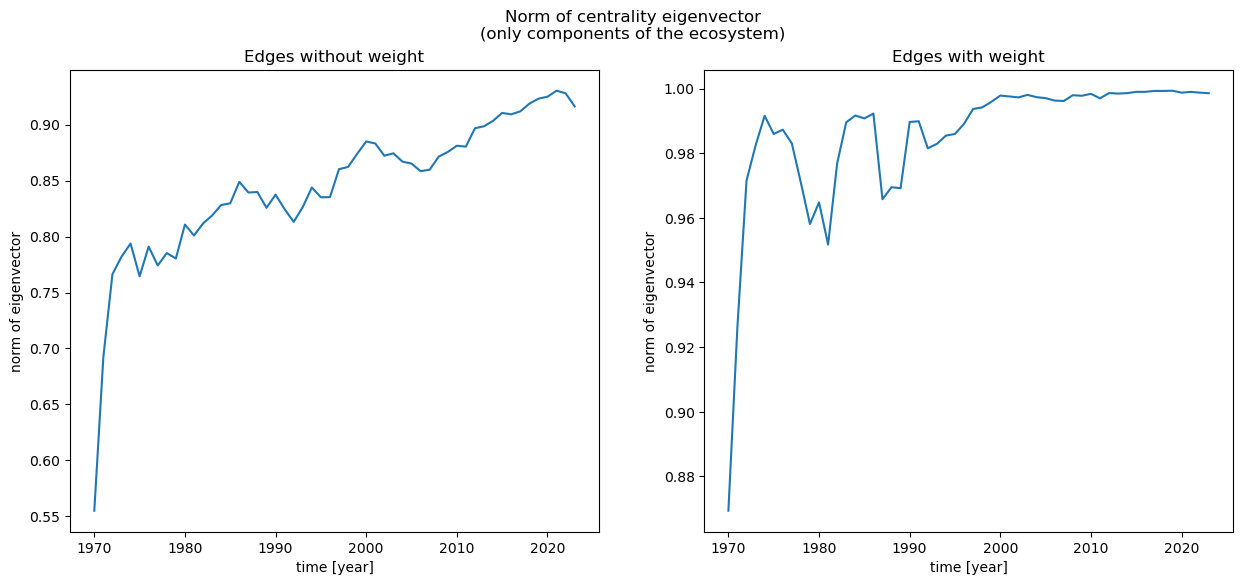

In [132]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.plot(ser_eigen_norm_sub_unweighted)
ax.set_xlabel('time [year]')
ax.set_ylabel('norm of eigenvector')
ax.set_title('Edges without weight')

ax = axes[1]
ax.plot(ser_eigen_norm_sub_weighted)
ax.set_xlabel('time [year]')
ax.set_ylabel('norm of eigenvector')
ax.set_title('Edges with weight')

fig.suptitle('Norm of centrality eigenvector\n(only components of the ecosystem)')
plt.show()

In [133]:
%%time

ser_pagerank_sub_unweighted = pd.Series(index = ser_network.index)
ser_pagerank_sub_weighted = pd.Series(index = ser_network.index)

print(f'Computing PageRank between {ser_network.index[0]} and {ser_network.index[-1]}...')
for t in range(ser_network.shape[0]):
    idx = ser_network.index[t]
    print(f'\r{idx}', end = '', flush = True)
    
    dict_pr_unweighted = nx.pagerank(ser_network[idx], weight = None)
    ser_pagerank_sub_unweighted[idx] = sum(dict_pr_unweighted[key] for key in ser_network_sub[idx].nodes())

    dict_pr_weighted = nx.pagerank(ser_network[idx], weight = 'weight')
    ser_pagerank_sub_weighted[idx] = sum(dict_pr_weighted[key] for key in ser_network_sub[idx].nodes())
    
print('\nDone.')

Computing PageRank between 1970 and 2023...
2023
Done.
CPU times: user 6.7 s, sys: 160 ms, total: 6.86 s
Wall time: 6.9 s


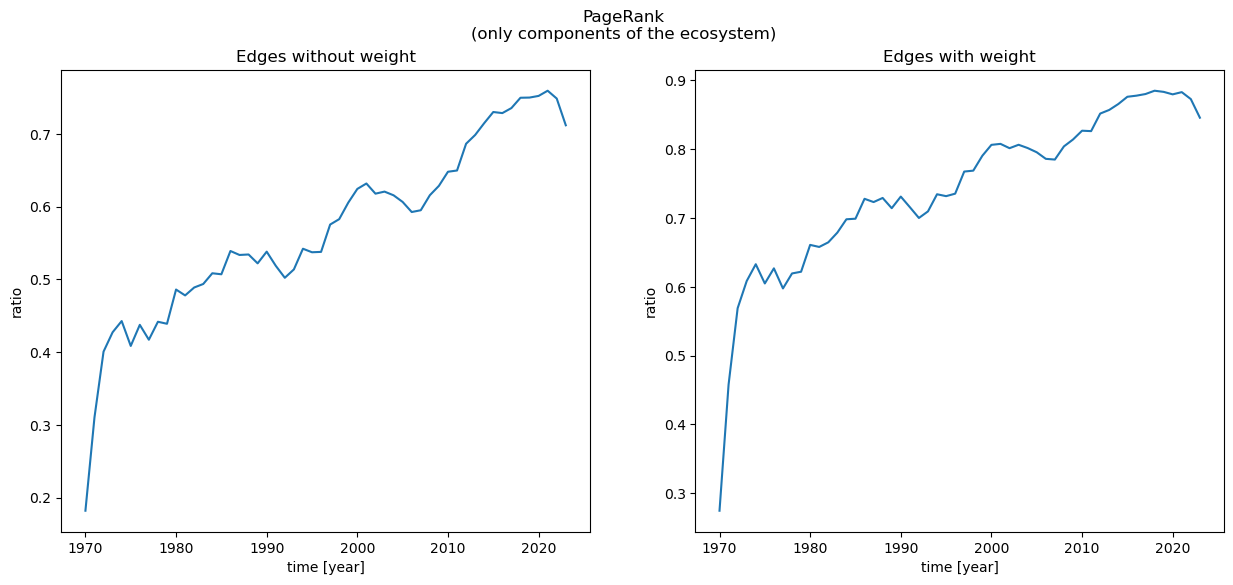

In [134]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.plot(ser_pagerank_sub_unweighted)
ax.set_xlabel('time [year]')
ax.set_ylabel('ratio')
ax.set_title('Edges without weight')

ax = axes[1]
ax.plot(ser_pagerank_sub_weighted)
ax.set_xlabel('time [year]')
ax.set_ylabel('ratio')
ax.set_title('Edges with weight')

fig.suptitle('PageRank\n(only components of the ecosystem)')
plt.show()